# 2nd Day Application:
## RKHS Regression (Year over Year)

We want to consider the following nonparameteric regression.
$$
\min_{f\in\mathcal{H}_K}\sum_{t=1}^T(y_t-f(x_t))^2 + \lambda\|f\|_{\mathcal{H}_K}^2
$$
where $f:\mathbb{R}^m\to\mathbb{R}$ is a real-valued function in a reproducing kernel Hilbert space $\mathcal{H}_K$ characterized by a Kernel $K:\mathbb{R}^m\times\mathbb{R}^m\to\mathbb{R}$. By the representer theorem, the solution to the above problem is given by
$$
f = \sum_{t=1}^T\alpha_tK(\cdot,x_t)
$$
for some $(\alpha_t)_{t=1}^T$. Thus, we may rewrite the problem as
$$
\min(y-K\alpha)'(y-K\alpha) + \lambda \alpha'K\alpha
$$
whose closed-form solution is given by
$$
\hat\alpha = (K+\lambda I_T)^{-1}y
$$
Prediction on a new sample is given by
$$
\hat y_{T+1} = \sum_{t=1}^T\hat\alpha_tK(x_{T+1},x_t)
$$

In [1]:
## Inflation Forecast
## Target variable: Year over Year inflation
import os
import time
import pickle
import sqlite3
import numba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import random
from functions import get_data, get_Gram_rbf
import xgboost as xgb
import tensorflow as tf

seed = 42

# Transform:
# Transformation = 'No Transform'
Transformation = 'Transform' 
# :Transforms according to the recommendations given by McCracken and Ng (2015) for all but Group 7 (Prices),
#  which are transformed as year over year growth
# Sample period: 1959.January - 2024.May

Target = 'Inflation'

price_var = ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'OILPRICEx', 'PPICMM', 'CPIAUCSL', 
             'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 
             'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA']

lags = 12 # Lags in log difference, lags=12 corresponds to year over year growth rate
X_used, Y_used, Date_used = get_data(Transformation, lags)

n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)

X_train = X_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

X_val = X_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

X_test = X_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(X_used), axis=0)==0
X_used_nnan = X_used.loc[:,nnan_idx]

X_train_nnan = X_used_nnan.loc[training_period,:]
X_val_nnan = X_used_nnan.loc[validation_period,:]
X_test_nnan = X_used_nnan.loc[forecast_period,:]

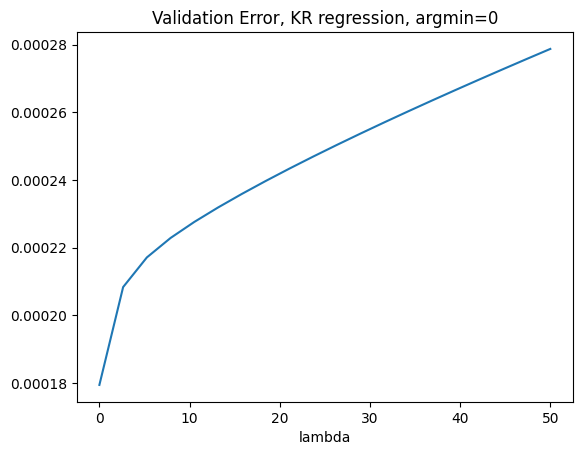

The RMSE of KR regression is 0.018900


In [2]:
#######################################################################################
###################################  RKHS regression  #################################
#######################################################################################
X_train_stzd = (X_train_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_val_stzd = (X_val_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_test_stzd = (X_test_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)    

gamma = 1/X_train_stzd.shape[1]
Kernel_Gram = get_Gram_rbf(X_train_stzd.values,X_train_stzd.values, n_train, n_train, gamma)
K_val = get_Gram_rbf(X_train_stzd.values, X_val_stzd.values, n_train, n_val, gamma)
K_test = get_Gram_rbf(X_train_stzd.values, X_test_stzd.values, n_train, n_test, gamma)

lam_list = np.linspace(1e-15,50,20)
val_err = np.zeros((n_val, len(lam_list)))
RKHS_dict = {}
for cv_i, lam in enumerate(lam_list):
    alpha_hat = np.linalg.inv(Kernel_Gram+lam*np.eye(n_train))@Y_train
    Y_hat = K_val@alpha_hat
    RKHS_dict[cv_i] = alpha_hat
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_KRR = np.mean(np.array(val_err)**2, axis=0)

plt.plot(lam_list, val_err_KRR)
plt.xlabel('lambda')
plt.title('Validation Error, KR regression, argmin=%i'%lam_list[min_idx])
plt.show()
KRR_lam = lam_list[min_idx]

Y_hat = K_test@RKHS_dict[min_idx]
test_err_KRR = Y_test.values - Y_hat
RMSE_KRR = np.sqrt(np.sum(test_err_KRR**2)/len(test_err_KRR))
print('The RMSE of KR regression is %f'%RMSE_KRR)

## Partially Linear RKHS Regression

We want to consider the following nonparameteric regression.
$$
\min_{f\in\mathcal{H}_K}\sum_{t=1}^T(y_t-v_t'\beta-f(w_t))^2 + \lambda\|f\|_{\mathcal{H}_K}^2
$$
where $f:\mathbb{R}^m\to\mathbb{R}$ is a real-valued function in a reproducing kernel Hilbert space $\mathcal{H}_K$ characterized by a Kernel $K:\mathbb{R}^m\times\mathbb{R}^m\to\mathbb{R}$. By the representer theorem, the solution to the above problem is given by
$$
f = \sum_{t=1}^T\alpha_tK(\cdot,w_t)
$$
for some $(\alpha_t)_{t=1}^T$. Thus, we may rewrite the problem as
$$
\min(y-V\beta-K\alpha)'(y-V\beta-K\alpha) + \lambda \alpha'K\alpha
$$
Solving the problem for $\beta$ first, we get the closed form solution
$$
\hat\beta = (V'V)^{-1}V'(y-K\alpha)
$$
Thus, the concentrated minimization problem is given by
$$
\min(y-K\alpha)'M_V(y-K\alpha) + \lambda \alpha'K\alpha
$$
where $M_V = I_T - V(V'V)^{-1}V'$. The solution for $\hat\alpha$ is given by
$$
\hat\alpha = (M_VK+\lambda I_T)^{-1}M_Vy
$$

In [3]:
num_lags = 2
V_used = X_used[np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,num_lags)])]
W_used = X_used.drop(np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,12)]),axis=1)

n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)

V_train = V_used.loc[training_period]
W_train = W_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

V_val = V_used.loc[validation_period]
W_val = W_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

V_test = V_used.loc[forecast_period]
W_test = W_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(W_used),axis=0)==0
W_used_nnan = W_used.loc[:,nnan_idx]

W_train_nnan = W_used_nnan.loc[training_period,:]
W_val_nnan = W_used_nnan.loc[validation_period,:]
W_test_nnan = W_used_nnan.loc[forecast_period,:]

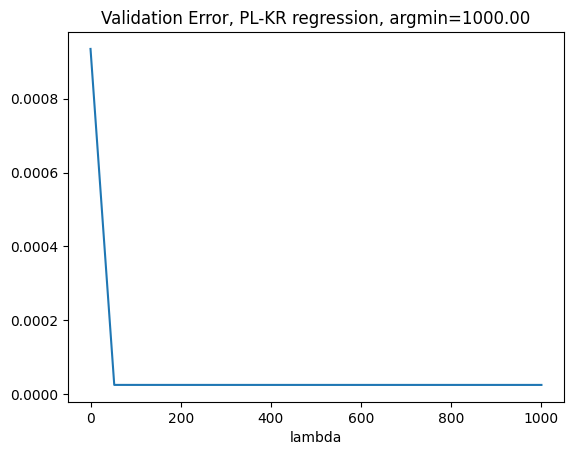

The RMSE of PL-KR regression is 0.003424


In [4]:
#######################################################################################
################################# Partially Linear RKHS ###############################
#######################################################################################
W_train_stzd = (W_train_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_val_stzd = (W_val_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_test_stzd = (W_test_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)

gamma = (1/W_test_stzd.shape[1])
Kernel_Gram = get_Gram_rbf(W_train_stzd.values,W_train_stzd.values, n_train,n_train,gamma)

K_val = get_Gram_rbf(W_train_stzd.values, W_val_stzd.values, n_train, n_val, gamma)
K_test = get_Gram_rbf(W_train_stzd.values, W_test_stzd.values, n_train, n_test, gamma)

alpha_hat_dict = {}
beta_hat_dict = {}

V_train_one = np.concatenate((np.ones((n_train,1)),V_train.values,),axis=1)
M_v = (np.identity(n_train)-V_train_one@np.linalg.inv(V_train_one.T@V_train_one)@V_train_one.T)
lambda_list = np.linspace(0,1000,20)
val_err = np.zeros((n_val,len(lambda_list)))

for cv_j, lam in enumerate(lambda_list):
    
    alpha_hat = np.linalg.inv(M_v@Kernel_Gram + lam*np.eye(n_train))@(M_v@Y_train)
    beta_hat = np.linalg.inv(V_train_one.T@V_train_one)@V_train_one.T@(Y_train-Kernel_Gram@alpha_hat)
    
    Y_hat = np.concatenate((np.ones((n_val,1)),V_val.values,),axis=1)@beta_hat + K_val@alpha_hat
    alpha_hat_dict[cv_j] = alpha_hat
    beta_hat_dict[cv_j] = beta_hat
    val_err[:,cv_j] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PLKR = np.mean(np.array(val_err)**2, axis=0)

plt.plot(lambda_list, val_err_PLKR)
plt.xlabel('lambda')
plt.title('Validation Error, PL-KR regression, argmin=%0.2f'%(lambda_list[min_idx]))
plt.show()

PLKR_lam = lambda_list[min_idx]

Y_hat = np.concatenate((np.ones((n_test,1)),V_test.values,),axis=1)@beta_hat_dict[min_idx] + K_test@alpha_hat_dict[min_idx]
test_err_PLKR = Y_test.values - Y_hat
RMSE_PLKR = np.sqrt(np.sum(test_err_PLKR**2)/len(test_err_PLKR))
print('The RMSE of PL-KR regression is %f'%RMSE_PLKR)

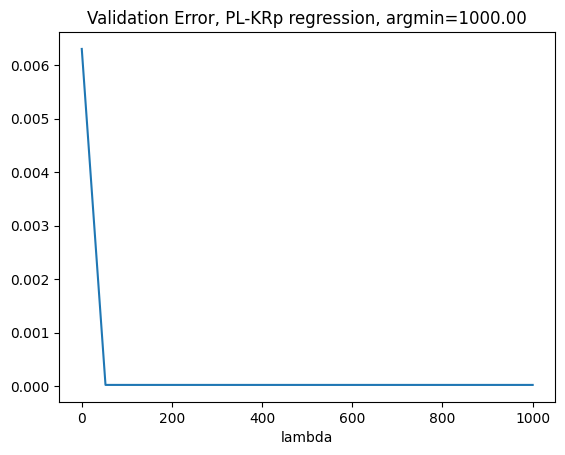

The RMSE of PL-KRp regression is 0.003422


In [5]:
#######################################################################################
##################### Partially Linear RKHS with price factors ########################
#######################################################################################
W_train_stzd2 = (W_train_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_val_stzd2 = (W_val_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_test_stzd2 = (W_test_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)

W_train_stzd = W_train_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]
W_val_stzd = W_val_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]
W_test_stzd = W_test_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]

gamma = (1/W_test_stzd.shape[1])
Kernel_Gram = get_Gram_rbf(W_train_stzd.values,W_train_stzd.values, n_train,n_train,gamma)

K_val = get_Gram_rbf(W_train_stzd.values, W_val_stzd.values, n_train, n_val, gamma)
K_test = get_Gram_rbf(W_train_stzd.values, W_test_stzd.values, n_train, n_test, gamma)

alpha_hat_dict = {}
beta_hat_dict = {}

V_train_one = np.concatenate((np.ones((n_train,1)),V_train.values,),axis=1)
M_v = (np.identity(n_train)-V_train_one@np.linalg.inv(V_train_one.T@V_train_one)@V_train_one.T)
lambda_list = np.linspace(0,1000,20)
val_err = np.zeros((n_val,len(lambda_list)))
for cv_j, lam in enumerate(lambda_list):
    
    alpha_hat = np.linalg.inv(M_v@Kernel_Gram + lam*np.eye(n_train))@(M_v@Y_train)
    beta_hat = np.linalg.inv(V_train_one.T@V_train_one)@V_train_one.T@(Y_train-Kernel_Gram@alpha_hat)
    
    Y_hat = np.concatenate((np.ones((n_val,1)),V_val.values,),axis=1)@beta_hat + K_val@alpha_hat
    alpha_hat_dict[cv_j] = alpha_hat
    beta_hat_dict[cv_j] = beta_hat
    val_err[:,cv_j] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_RKHSp = np.mean(np.array(val_err)**2, axis=0)

plt.plot(lambda_list, val_err_RKHSp)
plt.xlabel('lambda')
plt.title('Validation Error, PL-KRp regression, argmin=%0.2f'%(lambda_list[min_idx]))
plt.show()

PLKRp_lam = lambda_list[min_idx]

Y_hat = np.concatenate((np.ones((n_test,1)),V_test.values,),axis=1)@beta_hat_dict[min_idx] + K_test@alpha_hat_dict[min_idx]
test_err_PLKRp = Y_test.values - Y_hat
RMSE_PLKRp = np.sqrt(np.sum(test_err_PLKRp**2)/len(test_err_PLKRp))
print('The RMSE of PL-KRp regression is %f'%RMSE_PLKRp)

## RMSE Comparisions

In [6]:
lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,2)])
AR = LinearRegression(fit_intercept=True)
AR.fit(X_train[lags_label], Y_train)
Y_hat = AR.predict(X_test[lags_label])

test_err_AR = Y_test.values - Y_hat
RMSE_AR = np.sqrt(np.sum(test_err_AR**2)/len(test_err_AR))
print('The RMSE of AR2 model is %f'%RMSE_AR)

The RMSE of AR2 model is 0.003424


In [7]:
AR_rlt = [str(2),RMSE_AR]
KRR_rlt = [KRR_lam, RMSE_KRR]
PLKR_rlt = [PLKR_lam, RMSE_PLKR]
PLKRp_rlt = [PLKRp_lam, RMSE_PLKRp]

RESULTS = [AR_rlt, KRR_rlt, PLKR_rlt, PLKRp_rlt]
RESULTS_pd = pd.DataFrame(RESULTS)
RESULTS_pd.columns = ['parameters','RMSE']
RESULTS_pd.index = ['AR','KRR','PL-KR','PL-KRp']
display(RESULTS_pd)

,parameters,RMSE
AR,2,0.003424
KRR,0.0,0.018900
PL-KR,1000.0,0.003424
PL-KRp,1000.0,0.003422


In [8]:
rolling_RMSE_AR = np.zeros((n_test-24,))
rolling_RMSE_KRR = np.zeros((n_test-24,))
rolling_RMSE_PLKR = np.zeros((n_test-24,))
rolling_RMSE_PLKRp = np.zeros((n_test-24,))
for j in range(n_test-24):
    rolling_RMSE_AR[j] = np.sqrt(np.sum(test_err_AR[j:j+24]**2)/24)
    rolling_RMSE_KRR[j] = np.sqrt(np.sum(test_err_KRR[j:j+24]**2)/24)
    rolling_RMSE_PLKR[j] = np.sqrt(np.sum(test_err_PLKR[j:j+24]**2)/24)
    rolling_RMSE_PLKRp[j] = np.sqrt(np.sum(test_err_PLKRp[j:j+24]**2)/24)
    

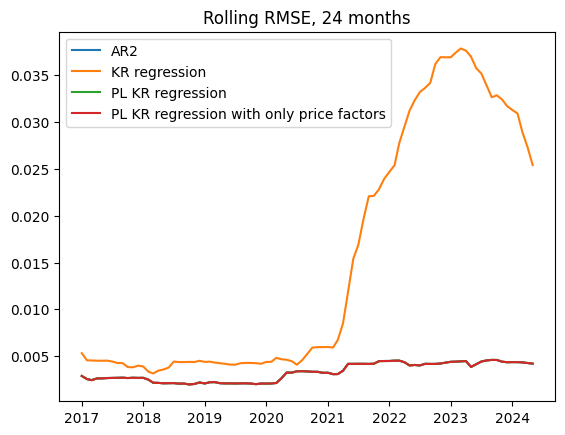

In [9]:
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR,label='AR2')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_KRR,label='KR regression')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PLKR,label='PL KR regression')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PLKRp,label='PL KR regression with only price factors')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()

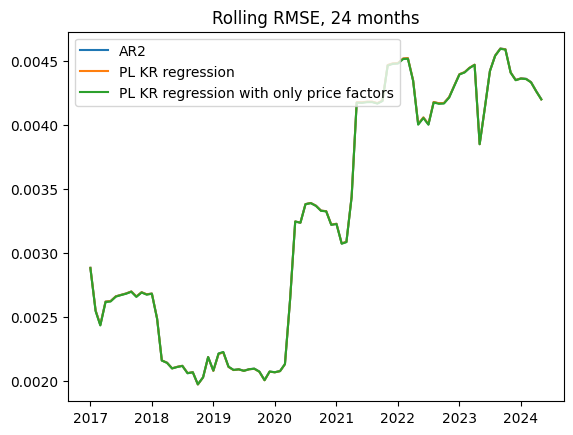

In [10]:
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR,label='AR2')
# plt.plot(Date_used[forecast_period][24:],rolling_RMSE_KRR,label='KR regression')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PLKR,label='PL KR regression')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PLKRp,label='PL KR regression with only price factors')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()